<a href="https://colab.research.google.com/github/CM134/RL_Project_02456/blob/chris/getting_started_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with PPO and ProcGen

Here's a bit of code that should help you get started on your projects.

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. You may want to inspect the file for more details.

In [1]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py

     |████████████████████████████████| 39.9 MB 41 kB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 203 kB 47.9 MB/s 
     |████████████████████████████████| 22.2 MB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 670 kB 44.6 MB/s 
     |████████████████████████████████| 3.1 MB 46.5 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but y

--2021-11-12 15:03:24--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  14.46K  --.-KB/s    in 0s      

2021-11-12 15:03:24 (60.5 MB/s) - ‘utils.py’ saved [14807/14807]



Hyperparameters. These values should be a good starting point. You can modify them later once you have a working implementation.

In [2]:
# Hyperparameters
total_steps = 15000000
num_envs = 32
num_levels = 10
num_steps = 256
num_epochs = 3
batch_size = 512
eps = .2
grad_eps = .5
value_coef = .5
entropy_coef = .01

In [3]:
feature_dim = 64
envname = 'starpilot'

Network definitions. We have defined a policy network for you in advance. It uses the popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. There is plenty of opportunity to experiment with architectures, so feel free to do that! Perhaps implement the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) (perhaps minus the LSTM).

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import make_env, Storage, orthogonal_init


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Encoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    return self.layers(x)


class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      x = x.contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)

    return dist, value

In [5]:
module = nn.Sequential(nn.Linear(3,5), nn.ReLU())
if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
  nn.init.orthogonal_(module.weight.data, gain)
  nn.init.constant_(module.bias.data, 0)
  print('true')
elif isinstance(module, nn.Sequential):
  print('seq')

else:
  print('no init')

seq


In [24]:
# Define environment
# check the utils.py file for info on arguments
env = make_env(num_envs, num_levels=num_levels, env_name = envname)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space.n)


encoder_in = env.observation_space.shape[0]
num_actions = env.action_space.n


# Define network
encoder = Encoder(encoder_in,feature_dim)
policy = Policy(encoder,feature_dim,num_actions)
policy.cuda()

# Define optimizer
# these are reasonable values but probably not optimal
optimizer = torch.optim.Adam(policy.parameters(), lr=5e-4, eps=1e-5)

# Define temporary storage
# we use this to collect transitions during each iteration
storage = Storage(
    env.observation_space.shape,
    num_steps,
    num_envs
)

# Run training
obs = env.reset()
step = 0
while step < total_steps:

  # Use policy to collect data for num_steps steps
  policy.eval()
  for _ in range(num_steps):
    

    # Use policy
    action, log_prob, value = policy.act(obs)
    
    # Take step in environment
    next_obs, reward, done, info = env.step(action)
    for i in range(len(done)):
      if done[i] == True:
        reward[i] = reward[i] - 5
        #print('step:',step, 'i:', i)
  
    # Store data
    storage.store(obs, action, reward, done, info, log_prob, value)
    
    # Update current observation
    obs = next_obs

  # Add the last observation to collected data
  _, _, value = policy.act(obs)
  storage.store_last(obs, value)

  # Compute return and advantage
  storage.compute_return_advantage()

  # Optimize policy
  policy.train()
  for epoch in range(num_epochs):

    # Iterate over batches of transitions
    generator = storage.get_generator(batch_size)
    for batch in generator:
      b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

      # Get current policy outputs
      new_dist, new_value = policy(b_obs)
      new_log_prob = new_dist.log_prob(b_action)

      # Clipped policy objective
      ratio = torch.exp((new_log_prob - b_log_prob))
      surr1 = ratio * b_advantage
      surr2 = torch.clamp(ratio, 1.0 - eps, 1.0 + eps) * b_advantage
      pi_loss = - torch.min(surr1, surr2).mean()

      # Clipped value function objective
      value_loss = (b_returns - new_value).pow(2).mean()

      # Entropy loss
      entropy_loss = new_dist.entropy()

      # Backpropagate losses
      loss = torch.mul(value_coef, value_loss) + pi_loss - torch.mul(entropy_coef, entropy_loss)
      loss.mean().backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps)

      # Update policy
      optimizer.step()
      optimizer.zero_grad()

  # Update stats
  step += num_envs * num_steps
  print(f'Step: {step}\tMean reward: {storage.get_reward()}')

print('Completed training!')
torch.save(policy.state_dict, 'checkpoint.pt')

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
Step: 8192	Mean reward: 3.65625


KeyboardInterrupt: ignored

In [21]:
print('step:',step, 'i:', i)

step: 507904 i: 31


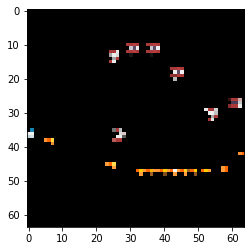

In [22]:
import matplotlib.pyplot as plt
import numpy as np
pic = np.moveaxis(np.array(batch[0][0,:,:,:].cpu()), 0, 2)
plt.imshow(pic)

Below cell can be used for policy evaluation and saves an episode to mp4 for you to view.

In [25]:
import imageio

# Make evaluation environment
eval_env = make_env(num_envs, start_level=num_levels, num_levels=num_levels, env_name= envname)
obs = eval_env.reset()

frames = []
total_reward = []

# Evaluate policy
policy.eval()
for _ in range(512):

  # Use policy
  action, log_prob, value = policy.act(obs)

  # Take step in environment
  obs, reward, done, info = eval_env.step(action)
  total_reward.append(torch.Tensor(reward))

  # Render environment and store
  frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
  frames.append(frame)

# Calculate average return
total_reward = torch.stack(total_reward).sum(0).mean(0)
print('Average return:', total_reward)

# Save frames as video
frames = torch.stack(frames)
imageio.mimsave('vid.mp4', frames, fps=25)

Average return: tensor(13.6369)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)